In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benhassinemouna","key":"a3184ba607cd1ff1dfddb14cb1aeb2f3"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c ashrae-energy-prediction

weather_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
building_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
weather_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip
!unzip /content/weather_test.csv.zip
!unzip /content/weather_train.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  /content/weather_train.csv.zip
  inflating: weather_train.csv       


READING DATA

In [0]:
%matplotlib inline
import json
import os
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection  import train_test_split
import numpy as np
import gc
from scipy.stats import norm # for scientific Computing
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [0]:
train_df=pd.read_csv('/content/train.csv', sep=',')
building_df=pd.read_csv('/content/building_metadata.csv', sep=',')
weather_train_df=pd.read_csv('/content/weather_train.csv',sep=',')
weather_test_df=pd.read_csv('/content/weather_test.csv',sep=',')
test_df=pd.read_csv('/content/test.csv',sep=',')

In [0]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_df data', building_df.shape)
print('Size of test_df data', test_df.shape)


Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_df data (1449, 6)
Size of test_df data (41697600, 4)


In [0]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [0]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

In [0]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [0]:
weather_train_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

In [0]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [0]:
weather_test_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

In [0]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [0]:
building_df.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

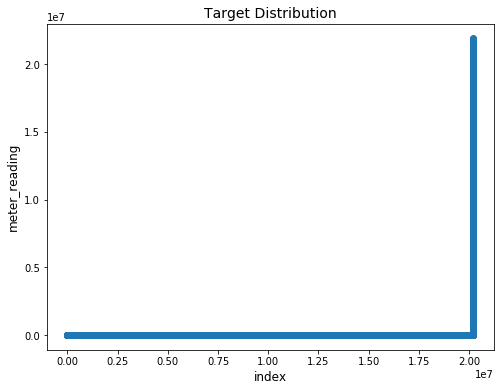

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['meter_reading'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('meter_reading', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

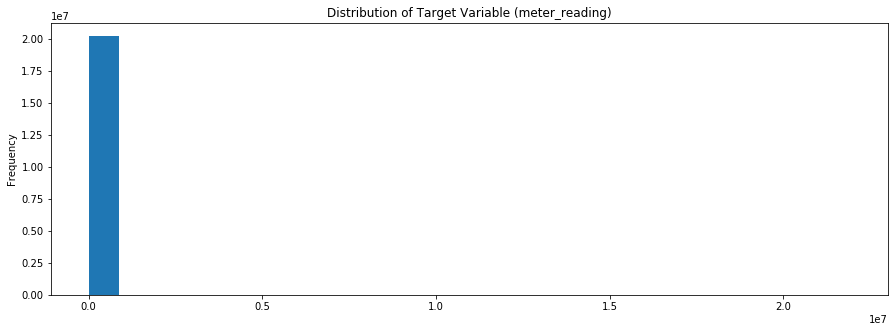

In [0]:
train_df['meter_reading'].plot(kind='hist',
                            bins=25,
                            figsize=(15, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

In [0]:
print("moyenne of missing values in the train_df dataset")
train_df.isnull().mean()

moyenne of missing values in the train_df dataset


building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [0]:
print("Percentage of missing values in the test_df dataset")
test_df.isnull().mean()

Percentage of missing values in the test_df dataset


row_id         0.0
building_id    0.0
meter          0.0
timestamp      0.0
dtype: float64

In [0]:
print("moyenne of missing values in the weather_test_df dataset")
weather_test_df.isnull().mean()

moyenne of missing values in the weather_test_df dataset


site_id               0.000000
timestamp             0.000000
air_temperature       0.000375
cloud_coverage        0.506588
dew_temperature       0.001179
precip_depth_1_hr     0.344781
sea_level_pressure    0.076702
wind_direction        0.044618
wind_speed            0.001659
dtype: float64

In [0]:
print("moyenne of missing values in the weather_train_df dataset")
weather_train_df.isnull().mean()

moyenne of missing values in the weather_train_df dataset


site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

In [0]:
print("Percentage of missing values in the building_df dataset")
building_df.isnull().mean()

Percentage of missing values in the building_df dataset


site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

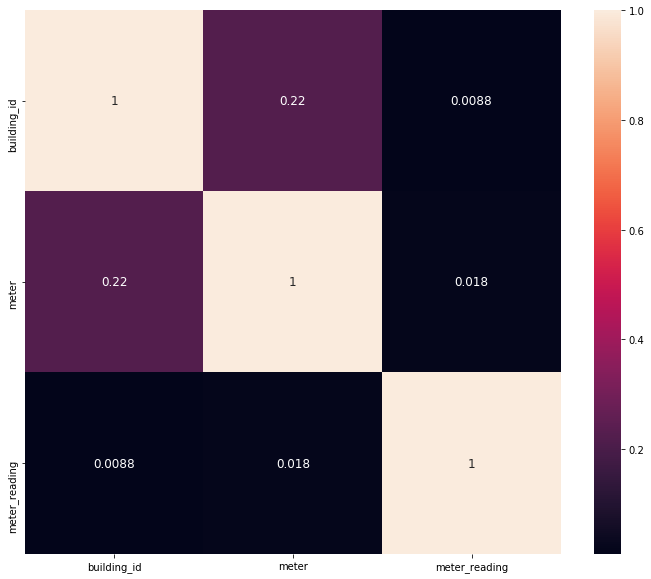

In [0]:
corrmat=train_df.corr()
fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,annot=True,annot_kws={'size': 12})


In [0]:
train_df.dtypes.value_counts()

int64      2
float64    1
object     1
dtype: int64

In [0]:
 Function to reduce the DF size

In [0]:

def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                     df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
reduce_memory_usage(train_df)
reduce_memory_usage(building_df)
reduce_memory_usage(weather_train_df)

reduce_memory_usage(weather_test_df)
reduce_memory_usage(test_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


feature engineering des dataframes

In [0]:

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
    
building_df['primary_use'] = building_df['primary_use'].astype('category')

Concaténation des dataframes

In [0]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_df

In [0]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

DATA visualistion:

In [0]:
print('the size of the train_df is',train_df.shape)
print('the size of the test_df is',test_df.shape)

the size of the train_df is (20216100, 16)
the size of the test_df is (41697600, 16)


In [0]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'], dtype=object)

In [0]:
test_df.columns.values

array(['row_id', 'building_id', 'meter', 'timestamp', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'], dtype=object)

In [0]:
print("moyenne of missing values in the train_df dataset")
train_df.isnull().mean()

moyenne of missing values in the train_df dataset


building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.599900
floor_count           0.826528
air_temperature       0.004781
cloud_coverage        0.436551
dew_temperature       0.004953
precip_depth_1_hr     0.185447
sea_level_pressure    0.060925
wind_direction        0.071678
wind_speed            0.007107
dtype: float64

In [0]:
print("moyenne of missing values in the test_df dataset")
test_df.isnull().mean()

moyenne of missing values in the test_df dataset


row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.589916
floor_count           0.826050
air_temperature       0.005322
cloud_coverage        0.468664
dew_temperature       0.006255
precip_depth_1_hr     0.187099
sea_level_pressure    0.060359
wind_direction        0.071435
wind_speed            0.007245
dtype: float64

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           category
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: category(1), datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int8(2)
memory usage: 751.9 MB


In [0]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           category
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: category(1), datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int8(2)
memory usage: 751.9 MB


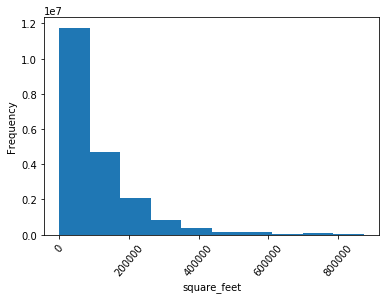

In [0]:
fig=train_df.square_feet.plot.hist(rot=50)
fig=plt.xlabel('square_feet')

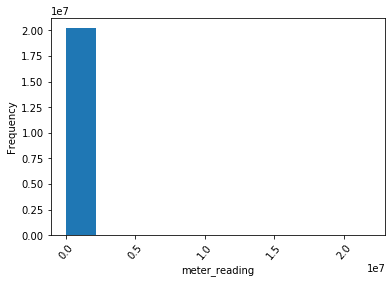

In [0]:
fig=train_df.meter_reading.plot.hist(rot=50)
fig=plt.xlabel('meter_reading')

In [0]:
train_df.primary_use.value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

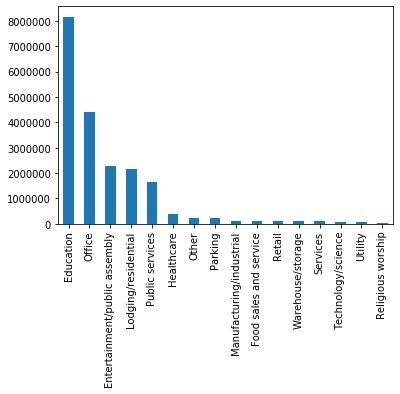

In [0]:
train_df['primary_use'].value_counts().plot.bar()

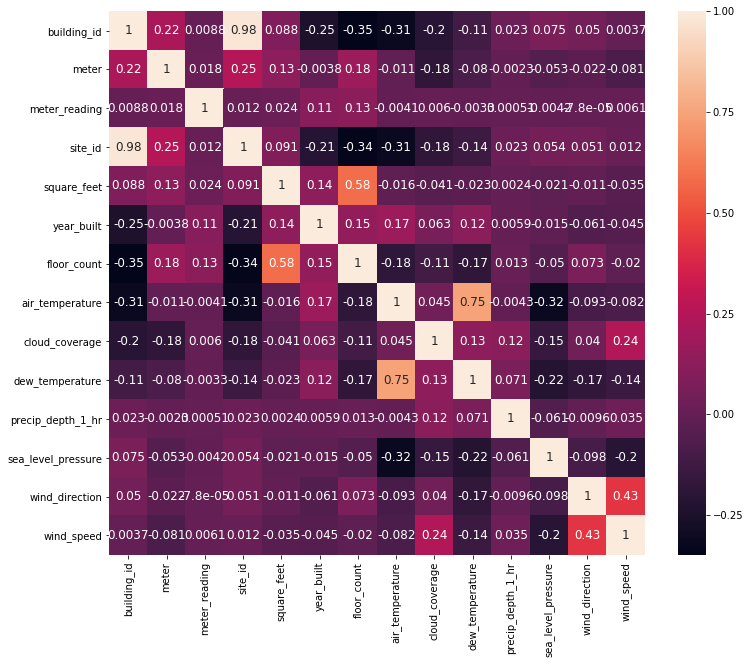

In [0]:
corrmat=train_df.corr()
fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,annot=True,annot_kws={'size': 12})

data cleaning

In [0]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)
train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 


In [0]:

train_df['cloud_coverage'].fillna(method='bfill', inplace = True)

train_df['wind_speed'].fillna(train_df['wind_speed'].mean(), inplace=True)
train_df['air_temperature'].fillna(train_df['air_temperature'].mean(), inplace=True)


test_df['cloud_coverage'].fillna(method='bfill', inplace = True)

test_df['cloud_coverage'].fillna(test_df['cloud_coverage'].mean(), inplace=True)

test_df['wind_speed'].fillna(test_df['wind_speed'].mean(), inplace=True)
test_df['air_temperature'].fillna(test_df['air_temperature'].mean(), inplace=True)

In [0]:
train_df = train_df.drop(columns=[ 'wind_direction', 'dew_temperature','precip_depth_1_hr','sea_level_pressure'])
test_df = test_df.drop(columns=['wind_direction', 'dew_temperature', 'precip_depth_1_hr' ,'sea_level_pressure'])

feature engineering

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)


test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

In [0]:
train_df['wind_speed'] = train_df['wind_speed'].astype('float32')
train_df['air_temperature'] = train_df['air_temperature'].astype('float32')

train_df['cloud_coverage'] = train_df['cloud_coverage'].astype('float32')
test_df['wind_speed'] = test_df['wind_speed'].astype('float32')
test_df['air_temperature'] = test_df['air_temperature'].astype('float32')

test_df['cloud_coverage'] = test_df['cloud_coverage'].astype('float32')

In [0]:
#eliminer l'heure
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
train_df ['timestamp'] =  pd.to_datetime(train_df['timestamp'])
test_df ['timestamp'] =  pd.to_datetime(test_df['timestamp'])
train_df['Month']=pd.DatetimeIndex(train_df['timestamp']).month
test_df['Month']=pd.DatetimeIndex(test_df['timestamp']).month
train_df['Day']=pd.DatetimeIndex(train_df['timestamp']).day
test_df['Day']=pd.DatetimeIndex(test_df['timestamp']).day
    
test_df['year_built'] = test_df['year_built']-1900
test_df['square_feet'] = np.log(test_df['square_feet'])

In [0]:
train_df = train_df.drop(columns=[ 'timestamp' ])
test_df = test_df.drop(columns=[ 'timestamp'])

Data preparation evaluation :

In [0]:
print("missing values in the train_df dataset")
train_df.isnull().sum()

missing values in the train_df dataset


building_id        0
meter              0
meter_reading      0
site_id            0
primary_use        0
square_feet        0
year_built         0
floor_count        0
air_temperature    0
cloud_coverage     0
wind_speed         0
Month              0
Day                0
dtype: int64

In [0]:
print("missing values in the test_df dataset")
test_df.isnull().sum()

missing values in the test_df dataset


row_id             0
building_id        0
meter              0
site_id            0
primary_use        0
square_feet        0
year_built         0
floor_count        0
air_temperature    0
cloud_coverage     0
wind_speed         0
Month              0
Day                0
dtype: int64

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 13 columns):
building_id        int16
meter              int8
meter_reading      float32
site_id            int8
primary_use        int8
square_feet        int32
year_built         int16
floor_count        int16
air_temperature    float32
cloud_coverage     float32
wind_speed         float32
Month              int64
Day                int64
dtypes: float32(4), int16(3), int32(1), int64(2), int8(3)
memory usage: 867.6 MB


Modeling

In [0]:
from sklearn import preprocessing
from keras import backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization,Activation,Flatten,TimeDistributed,AveragePooling1D
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras import regularizers

Using TensorFlow backend.


In [0]:
train_df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'wind_speed', 'Month', 'Day'],
      dtype='object')

In [0]:
X = train_df[['building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'wind_speed', 'Month', 'Day']]
y = train_df['meter_reading']

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state= 30)

In [0]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
def make_model(input_dim=10,metrics=root_mean_squared_error,loss='mse', optimizer="rmsprop",drop_rate=0.5):

  model = Sequential()
  model.add(LSTM(128,return_sequences=True, input_shape=(None,input_dim)))
  model.add(Dropout(drop_rate))
  model.add(BatchNormalization())
  model.add(LSTM(128,return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
  
  return model

In [0]:
def run_model(model,x_train,y_train,epochs=50,batch_size=500,verbose=1,validation_data=(x_val,y_val),callbacks =None):
  x_train = x_train.values[:]
  x_train= x_train.reshape((x_train.shape[0],1,x_train.shape[-1]))
  y_train = np.log1p(y_train)
  if validation_data != None:
    x_val = validation_data[0].values[:]
    x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[-1]))
    y_val = np.log1p(validation_data[-1])
      
  return model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_val,y_val),callbacks=callbacks)

In [0]:
model = make_model(input_dim=x_train.shape[-1],drop_rate=0.2)

In [0]:
es = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0001, patience=5, verbose=True, mode='auto')
history = run_model(model,x_train,y_train,epochs=20,batch_size=5000,verbose=1,validation_data=(x_val,y_val), callbacks =[es]) # callbacks =[mc, es]

Train on 14151270 samples, validate on 6064830 samples
Epoch 1/20
14151270/14151270 [==============================] - 401s 28us/step - loss: 4.1813 - root_mean_squared_error: 2.0447 - val_loss: 4.1135 - val_root_mean_squared_error: 2.0280
Epoch 2/20
14151270/14151270 [==============================] - 401s 28us/step - loss: 4.1809 - root_mean_squared_error: 2.0446 - val_loss: 4.1060 - val_root_mean_squared_error: 2.0262
Epoch 3/20
14151270/14151270 [==============================] - 404s 29us/step - loss: 4.1801 - root_mean_squared_error: 2.0444 - val_loss: 4.1100 - val_root_mean_squared_error: 2.0272
Epoch 4/20
14151270/14151270 [==============================] - 401s 28us/step - loss: 4.1802 - root_mean_squared_error: 2.0444 - val_loss: 4.1045 - val_root_mean_squared_error: 2.0258
Epoch 5/20
14151270/14151270 [==============================] - 400s 28us/step - loss: 4.1800 - root_mean_squared_error: 2.0444 - val_loss: 4.1043 - val_root_mean_squared_error: 2.0258
Epoch 6/20
14151270/

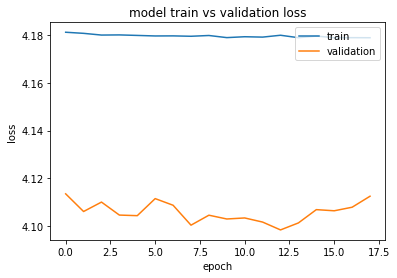

In [0]:
from matplotlib import pyplot
from numpy import array
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
model_json = model.to_json()
with open("history.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
# serialize weights to HDF5
model.save_weights("history.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
#from google.colab import files
#files.upload()

# load json and create model
from keras.models import model_from_json

json_file = open('/content/history.json', 'r')
loaded_model_json = json_file.read()

json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/history.h5")
print("Loaded model from disk")

#compile the model
#loaded_model.compile(loss='mse',optimizer =Adam(lr=1e-4) ,metrics=[rmse])
#score = loaded_model.predict(reshapeTest)


#prediction = np.expm1(score)
#df = pd.DataFrame(prediction)   
#df['row_id'] = row_ids
#df['meter_reading'] = df[0]
#df.drop([0], axis=1, inplace=True)
#df.to_csv('sub.csv', index=False, float_format='%.4f')


#!kaggle competitions submit -c ashrae-energy-prediction -f sub.csv -m "Message"

Loaded model from disk


In [0]:
#compile the model
x_test= train_df[['building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'wind_speed', 'Month', 'Day']]
x_test= x_test.values[:]
x_test= x_test.reshape((x_test.shape[0],1,x_test.shape[-1]))
y_test = np.log1p(y_train)
loaded_model.compile(loss='mse',optimizer =Adam(lr=1e-4) ,metrics=[root_mean_squared_error])
#score = loaded_model.predict(x_test)

In [0]:
score = loaded_model.predict(x_test)

In [0]:
prediction = np.expm1(score)
df = pd.DataFrame(prediction)   
df['row_id'] = row_ids
df['meter_reading'] = df[0]
df.drop([0], axis=1, inplace=True)
df.to_csv('sub.csv', index=False, float_format='%.4f')


!kaggle competitions submit -c ashrae-energy-prediction -f sub.csv -m "Message"